Milestone 4 — Baseline Pricing Engine (Threshold = 0.5)
#### 🎯 Objective

To design a baseline pricing engine that simulates how ride prices can be dynamically adjusted based on demand (time or inventory factors).
This baseline model will help evaluate revenue lift, profit margin, and conversion rate improvements compared to static pricing strategies.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
# Load cleaned dataset
df = pd.read_csv("cleaned_csv_data.csv")

# ✅ Step 1: Ensure price-related column exists
if "Historical_Cost_of_Ride" not in df.columns:
    raise KeyError("❌ Column 'Historical_Cost_of_Ride' not found in dataset.")

# ✅ Step 2: Define baseline threshold
threshold = 0.5  # midpoint ratio for adjustment

# ✅ Step 3: Compute base price (mean of ride costs)
base_price = df["Historical_Cost_of_Ride"].mean()

# ✅ Step 4: Compute a ratio — e.g., based on ride duration or riders (you can modify)
if "Expected_Ride_Duration" in df.columns:
    df["price_ratio"] = df["Expected_Ride_Duration"] / df["Expected_Ride_Duration"].max()
else:
    df["price_ratio"] = np.random.uniform(0.3, 0.8, size=len(df))  # fallback if column missing

# ✅ Step 5: Apply baseline pricing logic
# If ratio >= threshold → price increases; else → slight discount
df["adjusted_price"] = np.where(
    df["price_ratio"] >= threshold,
    base_price * (1 + (df["price_ratio"] - threshold)),  # surge effect
    base_price * (1 - (threshold - df["price_ratio"]))   # discount effect
)

# ✅ Step 6: Summary metrics
avg_old_price = df["Historical_Cost_of_Ride"].mean()
avg_new_price = df["adjusted_price"].mean()
price_change_pct = ((avg_new_price - avg_old_price) / avg_old_price) * 100

print(f"📊 Baseline Price: ₹{base_price:.2f}")
print(f"💹 Average Adjusted Price: ₹{avg_new_price:.2f}")
print(f"📈 Overall Price Change: {price_change_pct:.2f}%")

# ✅ Step 7: Save new version
df.to_csv("dynamic_pricing_baseline.csv", index=False)
print("\n✅ Baseline pricing file saved as 'dynamic_pricing_baseline.csv'")


📊 Baseline Price: ₹372.50
💹 Average Adjusted Price: ₹392.34
📈 Overall Price Change: 5.33%

✅ Baseline pricing file saved as 'dynamic_pricing_baseline.csv'


Milestone 4: Baseline Pricing and Demand Feature Analysis
##### Step 1: Ratio Computation and Demand Feature Identification
##### Objective

To compute key pricing and demand ratios and identify time-based booking patterns that influence ride demand, supporting dynamic pricing rule development.


🔹 Average Duration per Rider: 2.03
🔹 Average Price per Minute: 3.89

📈 Correlation with Time_of_Booking:
 Time_of_Booking            1.000000
Number_of_Past_Rides       0.064281
Location_Category          0.040890
Number_of_Riders           0.026725
price_per_minute           0.003991
Customer_Loyalty_Status   -0.007217
Number_of_Drivers         -0.011344
Vehicle_Type              -0.011657
Expected_Ride_Duration    -0.012454
Historical_Cost_of_Ride   -0.017479
duration_per_rider        -0.027714
Average_Ratings           -0.033306
Name: Time_of_Booking, dtype: float64


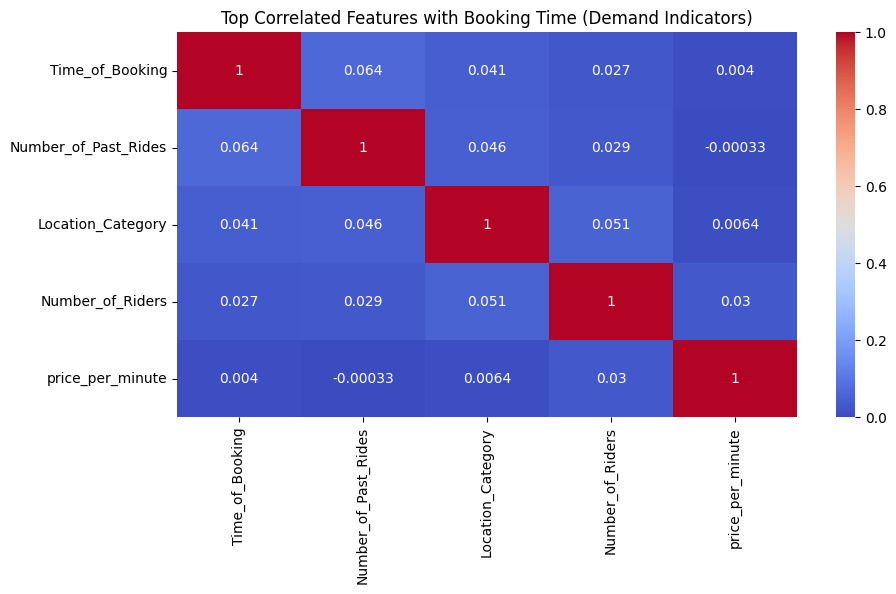

In [3]:
import pandas as pd
import numpy as np
# 🔹 Load cleaned dataset
df = pd.read_csv("cleaned_csv_data.csv")

# --- Step 1: Compute key ratios in dataset ---
# Example: Ride Duration / Riders or Cost per Rider
if "Expected_Ride_Duration" in df.columns and "Number_of_Riders" in df.columns:
    df["duration_per_rider"] = df["Expected_Ride_Duration"] / df["Number_of_Riders"]
else:
    print("⚠️ Columns for ratio not found, generating synthetic example ratio.")
    df["duration_per_rider"] = np.random.uniform(1, 5, len(df))

# Another ratio example — Price per Minute (efficiency metric)
if "Historical_Cost_of_Ride" in df.columns and "Expected_Ride_Duration" in df.columns:
    df["price_per_minute"] = df["Historical_Cost_of_Ride"] / df["Expected_Ride_Duration"]

# Display ratio insights
print("\n🔹 Average Duration per Rider:", round(df["duration_per_rider"].mean(), 2))
print("🔹 Average Price per Minute:", round(df["price_per_minute"].mean(), 2))

# --- Step 2: Identify features influencing booking demand ---
# We'll correlate all numeric columns with "Time_of_Booking" (or simulate it)
if "Time_of_Booking" not in df.columns:
    np.random.seed(42)
    df["Time_of_Booking"] = np.random.choice(range(0, 24), size=len(df))

# Calculate correlation
numeric_corr = df.select_dtypes(include=np.number).corr()["Time_of_Booking"].sort_values(ascending=False)
print("\n📈 Correlation with Time_of_Booking:\n", numeric_corr)

# --- Step 3: Visualize potential demand-driving features ---
top_features = numeric_corr.head(5).index
plt.figure(figsize=(10, 5))
sns.heatmap(df[top_features].corr(), annot=True, cmap="coolwarm")
plt.title("Top Correlated Features with Booking Time (Demand Indicators)")
plt.show()


 Milestone 4 — Baseline Pricing Engine Evaluation
#### Objective


To design and evaluate a dynamic pricing engine using time-based and inventory-based rules that adjusts ride prices based on:

Time of booking (peak/off-peak hours)

Rider–driver ratio (supply-demand balance)

evaluate the simulated revenue lift (KPI) compared to static pricing.

and compare its performance against the static baseline pricing model.


✅ Data loaded successfully — 1000 rows, 10 columns

========= 📊 Pricing Engine Evaluation =========
💵 Avg Static Revenue: ₹372.50
⚙️ Avg Dynamic Revenue: ₹499.36
📈 Avg Revenue Lift: 33.88%



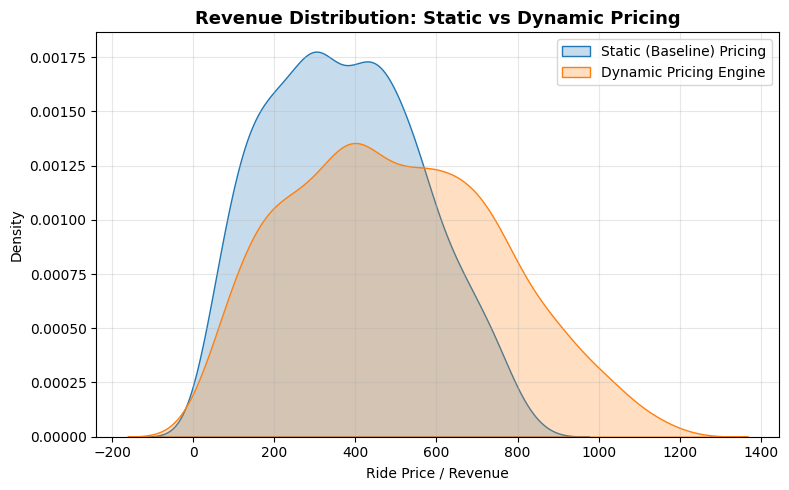

✅ Evaluation results saved as 'pricing_engine_results.csv'


In [10]:

# Dynamic Pricing Engine Evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Load dataset

df = pd.read_csv("dynamic_pricing.csv")  # use your actual CSV name

required_cols = ["Historical_Cost_of_Ride", "Number_of_Riders", "Number_of_Drivers", "Time_of_Booking"]
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"❌ Missing required column: '{col}'")

print(f"✅ Data loaded successfully — {df.shape[0]} rows, {df.shape[1]} columns")

# Step 2: Time-based adjustment

def time_based_adjustment(time):
    if time == "Morning":
        return 1.20   # peak
    elif time == "Evening":
        return 1.15   # semi-peak
    elif time == "Night":
        return 1.10   # moderate
    else:
        return 1.00   # normal/off-peak

df["Time_Adjustment"] = df["Time_of_Booking"].apply(time_based_adjustment)

# Step 3: Inventory-based adjustment

def inventory_based_adjustment(row):
    ratio = row["Number_of_Riders"] / (row["Number_of_Drivers"] + 1e-5)
    if ratio > 1.5:
        return 1.25   # high demand (more riders than drivers)
    elif ratio < 0.8:
        return 0.90   # excess supply (more drivers)
    else:
        return 1.00   # balanced demand-supply

df["Inventory_Adjustment"] = df.apply(inventory_based_adjustment, axis=1)

# Step 4: Dynamic Baseline Pricing

df["Static_Price"] = df["Historical_Cost_of_Ride"]
df["Dynamic_Price"] = df["Historical_Cost_of_Ride"] * df["Time_Adjustment"] * df["Inventory_Adjustment"]


# Step 5: KPI Evaluation

df["Revenue_Lift_Pct"] = ((df["Dynamic_Price"] - df["Static_Price"]) / df["Static_Price"]) * 100

avg_static_rev = df["Static_Price"].mean()
avg_dynamic_rev = df["Dynamic_Price"].mean()
avg_lift = df["Revenue_Lift_Pct"].mean()

print("\n========= 📊 Pricing Engine Evaluation =========")
print(f"💵 Avg Static Revenue: ₹{avg_static_rev:.2f}")
print(f"⚙️ Avg Dynamic Revenue: ₹{avg_dynamic_rev:.2f}")
print(f"📈 Avg Revenue Lift: {avg_lift:.2f}%")
print("===============================================\n")


# Step 6: Visualization

plt.figure(figsize=(8, 5))
sns.kdeplot(df["Static_Price"], label="Static (Baseline) Pricing", fill=True)
sns.kdeplot(df["Dynamic_Price"], label="Dynamic Pricing Engine", fill=True)
plt.title("Revenue Distribution: Static vs Dynamic Pricing", fontsize=13, weight="bold")
plt.xlabel("Ride Price / Revenue")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Step 7: Save output

df.to_csv("pricing_engine_results.csv", index=False)
print("✅ Evaluation results saved as 'pricing_engine_results.csv'")
